# TPLCNet 教程（逐模块详细讲解 + 真实温室数据可视化）

本 Notebook 参考 TimesNet 教程的写法，目标是：
- 解释 TPLCNet 的整体思路与输入/输出张量形状
- 对每一个核心模块逐段讲解（多尺度下采样、FFT 周期识别、1D→2D 重塑、2D 深度可分离卷积、多周期融合、多尺度预测融合）
- 在真实温室数据上画图：FFT 频谱 + top-K 周期标注、1D→2D 热力图（单通道与通道均值）、多尺度输出曲线对比

核心代码位置：
- `tplc_algo/models/tplc_model.py`
- `tplc_algo/models/layers.py`

## 0. 环境与依赖

说明：
- Python 3.11.14
- 建议使用你现有的 `TPLC_Net` conda 环境
- 下面的安装命令仅在缺依赖时使用

In [3]:
# 可选：安装依赖（在 Jupyter/VS Code Notebook 中推荐用 %pip）
# %pip install -r requirements.txt

import sys
from pathlib import Path

def find_project_root(start: Path) -> Path:
    """从当前目录向上查找包含 tplc_algo 的目录，作为 TPLC_Net 根目录。"""
    cur = start.resolve()
    for _ in range(10):
        if (cur / 'tplc_algo').exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    raise RuntimeError('未找到 TPLC_Net 根目录（缺少 tplc_algo）。请把工作目录切到 TPLC_Net 下再运行。')

ROOT = find_project_root(Path.cwd())
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print('ROOT =', ROOT)
print('Python =', sys.executable)

ROOT = D:\degree_code\scheme_1\TPLC_Net
Python = e:\anaconda\envs\TPLC_Net\python.exe


## 1. 包导入

我们将导入：
- 模型：`TPLCNet`
- 模块层：`MultiScaleGenerator`、`DepthwiseSeparableConv2d`、`extract_topk_periods`、`reshape_1d_to_2d/reshape_2d_to_1d`
- 训练器：`Trainer`
- 数据管线：`prepare_greenhouse_datasets/make_loaders`

In [4]:
import inspect
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

# 中文显示（按项目约定）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from tplc_algo.models.tplc_model import TPLCNet, MultiScaleGenerator
from tplc_algo.models.layers import (
    DepthwiseSeparableConv2d,
    extract_topk_periods,
    reshape_1d_to_2d,
    reshape_2d_to_1d,
)
from tplc_algo.train.trainer import Trainer, TrainConfig
from tplc_algo.pipeline import prepare_greenhouse_datasets, make_loaders

print('torch:', torch.__version__)
print('cuda available:', torch.cuda.is_available())

torch: 2.5.1+cu121
cuda available: True


## 2. TPLCNet 总体结构（先建立直觉）

### 2.1 输入/输出张量约定
- 输入 $x$：形状 `[B, T, C_in]`
  - `B`：batch size
  - `T = seq_len`：历史窗口长度
  - `C_in = input_dim`：输入变量个数（多变量时序）
- 输出 $\hat{y}$：形状 `[B, pred_len, C_out]`
  - `pred_len`：预测步数
  - `C_out = target_dim`：目标变量维度

### 2.2 核心思想（对应源码的“主链路”）
TPLCNet 可以理解为：
1) **多尺度**：对输入序列做多次 `avg_pool1d(stride=2)` 得到不同时间分辨率的序列（短期/中期/长期）。
2) **找周期**：在每个尺度上做 FFT，挑 top-K 主周期（`extract_topk_periods`）。
3) **按周期重排成 2D**：把 1D 序列按周期切块，重排为二维网格（时间块 × 周期相位）。
4) **2D 卷积抽特征**：用 2D 深度可分离卷积提取局部模式（参数量更小）。
5) **多周期融合**：对每个周期得到一个特征，再对 FFT 幅值做 softmax 得到权重，做加权求和。
6) **多尺度融合**：每个尺度都会输出一个预测，最终将各尺度预测相加。

这套流程的好处：
- FFT 把“周期性信息”显式化，模型不需要从零学到周期。
- 1D→2D 让卷积能同时看“周期相位内的局部结构”和“跨周期的变化”。
- 多尺度让模型同时覆盖不同时间跨度的规律。

## 3. 模块 A：MultiScaleGenerator（多尺度生成器）

位置：`tplc_algo/models/tplc_model.py`

### 3.1 它做了什么
输入通常会先转成 `C-first`：`[B, C, T]`，然后重复做 `avg_pool1d(kernel_size=2, stride=2)` 得到多尺度序列：
- 尺度 0：长度 $L_0 = T$
- 尺度 1：长度 $L_1 \approx T/2$
- 尺度 2：长度 $L_2 \approx T/4$

### 3.2 为什么用平均池化
- 实现简单稳定（不引入额外参数）
- 类似低通滤波：更长周期在低分辨率上更“显眼”，FFT 更容易挑到主周期

### 3.3 你应该关注的形状
- 输入：`x [B, C, T]`
- 输出：`List[Tensor]`，每个元素是 `[B, C, L_m]`

In [5]:
print(inspect.getsource(MultiScaleGenerator))

class MultiScaleGenerator(nn.Module):
    """多尺度序列生成：使用平均池化实现 stride=2 的下采样。"""

    def __init__(self, num_scales: int) -> None:
        super().__init__()
        self.num_scales = int(num_scales)

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        # x: [B, C, T]
        scales = [x]
        cur = x
        for _ in range(self.num_scales):
            # 平均池化下采样，保持变量一致
            cur = F.avg_pool1d(cur, kernel_size=2, stride=2, ceil_mode=False)
            scales.append(cur)
        return scales



## 4. 模块 B：extract_topk_periods（FFT 周期识别）

位置：`tplc_algo/models/layers.py`

### 4.1 它解决的问题
给定一个长度为 `L` 的序列，想知道其中最强的周期结构（比如“每 24 步一个循环”）。

### 4.2 多变量的处理方式（关键细节）
输入是 `[B, C, L]` 时：
- 先在时间维做 LayerNorm：减少不同变量量纲差异对 FFT 的影响
- 再对通道求和得到 `[B, L]`，用这个“聚合序列”做 rFFT

### 4.3 输出是什么
- `periods [K]`：top-K 周期长度（整数）
- `amplitudes [K]`：对应的频域幅值

在 `TPLCNet.forward()` 中会对 `amplitudes` 做 softmax 得到权重 $w_k$，用于多周期融合：
$$fused = \sum_{k=1}^{K} w_k \cdot feat_k$$

In [6]:
print(inspect.getsource(extract_topk_periods))

def extract_topk_periods(
    x: torch.Tensor,
    top_k: int,
    eps: float = 1e-6,
) -> PeriodInfo:
    """基于 FFT 从序列中提取 top_k 个显著周期。

    参考 scheme_1_algo.md：对归一化后的多变量序列求和得到 1D 序列，再 FFT，选振幅最大的前 K 个频率。

    参数
    - x: [B, C, L] 或 [B, L]，数值序列
    返回
    - periods: [K]，周期长度（整数）
    - amplitudes: [K]，对应振幅（用于 softmax 权重）
    """

    if x.dim() == 3:
        # 对每个变量在时间维做 LayerNorm，再沿变量维求和
        b, c, l = x.shape
        x_ln = F.layer_norm(x, normalized_shape=(l,))
        seq = x_ln.sum(dim=1)  # [B, L]
    elif x.dim() == 2:
        seq = x
        l = x.shape[-1]
    else:
        raise ValueError("x 维度必须是 [B,C,L] 或 [B,L]")

    # rFFT: [B, L//2 + 1]
    fft = torch.fft.rfft(seq, dim=-1)
    mag = torch.abs(fft)  # [B, F]
    mag = mag.mean(dim=0)  # [F]
    if mag.numel() > 0:
        mag[0] = 0.0  # 去掉直流分量

    # 若长度过短，直接返回周期=1
    if mag.numel() <= 1:
        periods = torch.ones(top_k, dtype=torch.long, device=x.device)
        amps = torch.ones(top_k, dtype=torch.float32, dev

## 5. 模块 C：reshape_1d_to_2d / reshape_2d_to_1d（1D↔2D 重塑）

位置：`tplc_algo/models/layers.py`

### 5.1 1D→2D 的直觉
识别出周期 `p` 后，把 1D 序列按 `p` 切块重排：
- 输入：`x [B, C, L]`
- padding 到 `L_pad` 是 `p` 的整数倍
- `rows = L_pad / p`
- 输出：`z [B, C, rows, p]`

其中：
- `rows` 可以理解为“有多少个周期块”
- `p` 是“周期内的相位位置（0..p-1）”

### 5.2 2D→1D
把 `[B, C, rows, p]` 展平回 `[B, C, L_pad]`，再裁剪回原始长度 `L`（去掉 padding）。

### 5.3 为什么这一步关键
它把“周期结构”显式地编码到二维网格，使得 2D 卷积能够：
- 在周期相位维上捕捉局部形状
- 在跨周期（rows）维上捕捉周期之间的变化

In [7]:
print(inspect.getsource(reshape_1d_to_2d))
print(inspect.getsource(reshape_2d_to_1d))

def reshape_1d_to_2d(x: torch.Tensor, period: int) -> Tuple[torch.Tensor, int]:
    """将 1D 序列按周期重塑为 2D 图像。

    输入 x: [B, C, L]
    输出 z: [B, C, rows, period]，其中 rows = ceil(L/period)
    同时返回原始长度（便于反向裁剪）。
    """

    x_pad, orig_len = pad_to_multiple(x, period)
    b, c, l_pad = x_pad.shape
    rows = l_pad // period
    z = x_pad.view(b, c, rows, period)
    return z, orig_len

def reshape_2d_to_1d(z: torch.Tensor, orig_len: int) -> torch.Tensor:
    """将 2D 特征展平回 1D，并裁剪回 orig_len。"""

    b, c, rows, period = z.shape
    x = z.reshape(b, c, rows * period)
    return x[..., :orig_len]



## 6. 模块 D：DepthwiseSeparableConv2d（2D 深度可分离卷积）

位置：`tplc_algo/models/layers.py`

### 6.1 为什么用深度可分离卷积
因为每个尺度会取 K 个周期，每个周期都会跑一次 2D 卷积。

深度可分离卷积把一次标准卷积分成两步：
1) Depthwise：每个输入通道独立卷积（groups=C_in）
2) Pointwise：1×1 卷积做通道混合

这样参数量和计算量都更小，尤其在 `C_in` 比较大时优势明显。

### 6.2 在 TPLCNet 中它扮演的角色
它负责在 `z [B, C, rows, p]` 这个“周期图像”上抽取局部时空模式，输出用于后续的多周期融合与预测头。

In [8]:
print(inspect.getsource(DepthwiseSeparableConv2d))

class DepthwiseSeparableConv2d(nn.Module):
    """2D 深度可分离卷积：DepthwiseConv2d(groups=in_channels) + PointwiseConv2d(1x1)。"""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        padding: int | None = None,
        bias: bool = False,
    ) -> None:
        super().__init__()
        if padding is None:
            padding = kernel_size // 2
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            padding=padding,
            groups=in_channels,
            bias=bias,
        )
        self.pointwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            padding=0,
            bias=bias,
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.act = nn.GELU()

    def forward(self, x: 

## 7. 模块 E：TPLCNet（总模型）

位置：`tplc_algo/models/tplc_model.py`

### 7.1 每个尺度 m 的处理流程
对尺度 `m` 的序列 `x_m [B, C, L_m]`：
1) `extract_topk_periods(x_m)` 得到 `periods[K]` 与 `amplitudes[K]`
2) 对每个周期 `p_k`：
   - `reshape_1d_to_2d` 得到 `z2d [B, C, rows, p_k]`
   - `conv2d(z2d)` 得到周期特征
   - `reshape_2d_to_1d` 回到 `feat_k [B, hidden, L_m]`
3) 计算 softmax 权重并做多周期融合：`fused [B, hidden, L_m]`
4) 预测头：
   - `time_projs[m]`：把长度维 `L_m -> pred_len`（每个尺度一个线性层）
   - `channel_proj`：把 `hidden -> target_dim`（共享线性层）

### 7.2 多尺度融合
每个尺度都会得到一个 `y_m [B, pred_len, target_dim]`，最后做求和得到最终输出：
$$\hat{y} = \sum_m y_m$$

### 7.3 一个容易忽略的实现点
`time_projs[m]` 的输入长度在构造时是固定的（按 `seq_len//(2**m)` 计算），
所以 forward 中对实际 `L_m` 会做截断/补零对齐。这也是为什么你看到代码里有 pad/截断逻辑。

In [9]:
print(inspect.getsource(TPLCNet))

class TPLCNet(nn.Module):
    """TPLCNet：多尺度 + FFT 周期识别 + 1D→2D + 深度可分离卷积 + 多周期/多尺度融合。"""

    def __init__(
        self,
        input_dim: int,
        target_dim: int,
        seq_len: int,
        pred_len: int,
        num_scales: int = 2,
        top_k_periods: int = 3,
        hidden_dim: int = 64,
        dw_kernel: int = 3,
    ) -> None:
        super().__init__()
        self.input_dim = int(input_dim)
        self.target_dim = int(target_dim)
        self.seq_len = int(seq_len)
        self.pred_len = int(pred_len)
        self.num_scales = int(num_scales)
        self.top_k_periods = int(top_k_periods)
        self.hidden_dim = int(hidden_dim)

        self.multi_scale = MultiScaleGenerator(num_scales=self.num_scales)
        self.conv2d = DepthwiseSeparableConv2d(
            in_channels=self.input_dim,
            out_channels=self.hidden_dim,
            kernel_size=dw_kernel,
        )

        # 多尺度 head：每个尺度一个“时间映射线性层”，再共享一个“通道映射线性层”
        self.time_projs = nn.Mod

## 8. 训练与评估（Trainer）

位置：`tplc_algo/train/trainer.py`

Trainer 负责把“模型 + DataLoader + loss/metric + 优化器 + 日志/进度条”串起来。

你在代码里可以重点关注：
- `TrainConfig`：训练超参（学习率、epoch、device、梯度裁剪等）
- Windows 终端兼容：tqdm 进度条启用 ASCII（避免乱码/方块）
- 指标：MAE/RMSE（见 `tplc_algo/eval/metrics.py`）

下面直接把关键类源码打印出来，便于对照阅读。

In [10]:
print(inspect.getsource(TrainConfig))
print(inspect.getsource(Trainer))

@dataclass
class TrainConfig:
    epochs: int = 10
    lr: float = 1e-3
    weight_decay: float = 0.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    ckpt_path: Path | None = None
    show_progress: bool = True
    progress_granularity: str = "batch"  # "batch" | "epoch" | "none"

class Trainer:
    """最小可用训练器（MSE 损失 + MAE/RMSE 评估）。"""

    def __init__(self, model: nn.Module, cfg: TrainConfig) -> None:
        self.model = model.to(cfg.device)
        self.cfg = cfg
        self.loss_fn = nn.MSELoss()
        self.optim = torch.optim.AdamW(
            self.model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay
        )

    def fit(self, train_loader: DataLoader, val_loader: Optional[DataLoader] = None) -> Dict[str, list[float]]:
        history: Dict[str, list[float]] = {"train_loss": [], "val_loss": [], "val_mae": [], "val_rmse": []}

        best_val = None
        tqdm_fn = _maybe_tqdm() if self.cfg.show_progress else None
        epoch_pbar: Any | Non

## 9. 真实温室数据：加载与可视化

你希望“在真实温室数据上画”，并且热力图要同时展示：
- 某一个变量通道（单通道）
- 通道聚合（这里用通道均值）

本节会画 3 类图：
1) FFT 频谱图（标注 top-K 周期）
2) 1D→2D 重排热力图（单通道 + 通道均值）
3) 多尺度输出曲线（各尺度输出 vs 融合输出 vs 真实值；含反标准化）

In [11]:
# 尝试用相对路径自动定位（找不到就手动改）
candidates = [
    ROOT.parent / 'datasets' / '自主温室挑战赛',
    ROOT.parent.parent / 'datasets' / '自主温室挑战赛',
]
dataset_root = None
for p in candidates:
    if p.exists():
        dataset_root = p
        break

print('auto dataset_root:', dataset_root)
# 如果这里是 None，请手动指定，例如：
# dataset_root = Path(r'..\datasets\自主温室挑战赛')

auto dataset_root: D:\degree_code\scheme_1\datasets\自主温室挑战赛


In [12]:
from pathlib import Path

team = 'AICU'
seq_len_real = 96
pred_len_real = 24
batch_size_real = 32

if dataset_root is None:
    raise RuntimeError('dataset_root 为 None。请先在上一节手动设置真实温室数据路径。')

prepared = prepare_greenhouse_datasets(
    dataset_root=Path(dataset_root),
    team=team,
    seq_len=seq_len_real,
    pred_len=pred_len_real,
    stride=1,
)
_, _, _ = make_loaders(prepared, batch_size=batch_size_real)

x0, y0 = prepared.test_ds[0]
x0 = x0.unsqueeze(0)
y0 = y0.unsqueeze(0)

model_vis = TPLCNet(
    input_dim=len(prepared.feature_cols),
    target_dim=len(prepared.target_cols),
    seq_len=seq_len_real,
    pred_len=pred_len_real,
    num_scales=2,
    top_k_periods=3,
    hidden_dim=64,
)
model_vis.eval()

print('x0:', tuple(x0.shape), 'y0:', tuple(y0.shape))
print('targets:', prepared.target_cols)

D:\degree_code\scheme_1\TPLC_Net\tplc_algo\data\greenhouse_dataset.py:32: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


x0: (1, 96, 119) y0: (1, 24, 3)
targets: ['Tair', 'Rhair', 'CO2air']


### 9.0 自动加载“训练后 best”（推荐）

如果你已经跑过训练/调参，最稳妥的方式是：
1) **自动从** `results/tplcnet_greenhouse_{team}_*` **里选最新一次实验**
2) 读取该实验的 `artifacts/config.json` 推断训练时的超参（`num_scales/top_k_periods/hidden_dim/seq_len/pred_len`）
3) 按配置重建 `prepared` 与 `model_vis`，并加载该实验的 `checkpoints/tplcnet_best.pt`

如果 `results` 下找不到配置，则会回退到 `checkpoints/tplcnet_best.pt`（或 checkpoints 里最新的 `.pt`）。

In [13]:
import json
from pathlib import Path

def _pick_latest_dir(dirs: list[Path]) -> Path | None:
    dirs = [d for d in dirs if d.exists() and d.is_dir()]
    if not dirs:
        return None
    return sorted(dirs, key=lambda p: p.stat().st_mtime, reverse=True)[0]

# 1) 优先：从 results 里找最新实验
exp_dir = None
results_root = ROOT / 'results'
if results_root.exists():
    exp_dirs = list(results_root.glob(f'tplcnet_greenhouse_{team}_*'))
    exp_dir = _pick_latest_dir(exp_dirs)

print('picked exp_dir:', exp_dir)

config = None
ckpt_path = None

# 2) 读取 config.json（若存在）
if exp_dir is not None:
    cfg_path = exp_dir / 'artifacts' / 'config.json'
    if cfg_path.exists():
        config = json.loads(cfg_path.read_text(encoding='utf-8'))
        print('loaded config:', cfg_path)

    # 3) 确定 best checkpoint 路径
    ckpt_txt = exp_dir / 'artifacts' / 'checkpoint_path.txt'
    if ckpt_txt.exists():
        ckpt_path = Path(ckpt_txt.read_text(encoding='utf-8').strip())
    else:
        cand = exp_dir / 'checkpoints' / 'tplcnet_best.pt'
        if cand.exists():
            ckpt_path = cand

# 4) 回退：项目级 checkpoints
if ckpt_path is None:
    ckpt_candidates = [
        ROOT / 'checkpoints' / 'tplcnet_best.pt',
    ]
    ckpt_dir = ROOT / 'checkpoints'
    if ckpt_dir.exists():
        ckpt_candidates += sorted(ckpt_dir.glob('*.pt'), key=lambda p: p.stat().st_mtime, reverse=True)
    ckpt_path = next((p for p in ckpt_candidates if p.exists()), None)

print('checkpoint picked:', ckpt_path)

# 5) 如果有 config：按训练配置重建 prepared / model_vis（保证超参一致）
if config is not None:
    cfg_seq = int(config.get('seq_len', seq_len_real))
    cfg_pred = int(config.get('pred_len', pred_len_real))
    model_cfg = config.get('model', {}) or {}

    seq_len_real = cfg_seq
    pred_len_real = cfg_pred

    # dataset_root：优先用你前面设置的 dataset_root；如果为空，再用 config 里的
    cfg_dataset_root = config.get('dataset_root', None)
    if (dataset_root is None) and cfg_dataset_root:
        dataset_root = Path(cfg_dataset_root)

    if dataset_root is None:
        raise RuntimeError('dataset_root 仍为 None。请手动设置真实温室数据路径。')

    prepared = prepare_greenhouse_datasets(
        dataset_root=Path(dataset_root),
        team=team,
        seq_len=seq_len_real,
        pred_len=pred_len_real,
        stride=int(config.get('stride', 1)),
    )
    _, _, _ = make_loaders(prepared, batch_size=int(config.get('train', {}).get('batch_size', batch_size_real)))

    x0, y0 = prepared.test_ds[0]
    x0 = x0.unsqueeze(0)
    y0 = y0.unsqueeze(0)

    model_vis = TPLCNet(
        input_dim=len(prepared.feature_cols),
        target_dim=len(prepared.target_cols),
        seq_len=seq_len_real,
        pred_len=pred_len_real,
        num_scales=int(model_cfg.get('num_scales', 2)),
        top_k_periods=int(model_cfg.get('top_k_periods', 3)),
        hidden_dim=int(model_cfg.get('hidden_dim', 64)),
    )
    model_vis.eval()

    print('rebuilt by config: seq_len_real=', seq_len_real, 'pred_len_real=', pred_len_real)
    print('model cfg:', {k: getattr(model_vis, k, None) for k in ['num_scales', 'top_k_periods', 'hidden_dim']})
    print('x0:', tuple(x0.shape), 'y0:', tuple(y0.shape))

# 6) 加载 checkpoint（如果找得到）
if ckpt_path is None:
    print('未找到 checkpoint：将继续使用未训练的 model_vis（9.3 曲线可能不直观）。')
else:
    ckpt = torch.load(ckpt_path, map_location='cpu')
    state_dict = ckpt.get('state_dict', ckpt)
    try:
        model_vis.load_state_dict(state_dict, strict=True)
        print('checkpoint 加载成功（strict=True）。')
    except Exception as e:
        missing, unexpected = model_vis.load_state_dict(state_dict, strict=False)
        print('checkpoint 加载为 strict=False（通常是超参不一致导致）。')
        print('error:', repr(e))
        if missing:
            print('missing keys:', missing[:20], '...' if len(missing) > 20 else '')
        if unexpected:
            print('unexpected keys:', unexpected[:20], '...' if len(unexpected) > 20 else '')
        print('建议：优先使用 results 中的 config.json 重建模型；或手动把 model_vis 的超参改成训练时一致。')

    model_vis.eval()

picked exp_dir: D:\degree_code\scheme_1\TPLC_Net\results\tplcnet_greenhouse_AICU_20251215_160814
loaded config: D:\degree_code\scheme_1\TPLC_Net\results\tplcnet_greenhouse_AICU_20251215_160814\artifacts\config.json
checkpoint picked: D:\degree_code\scheme_1\TPLC_Net\results\tplcnet_greenhouse_AICU_20251215_160814\checkpoints\tplcnet_best.pt


D:\degree_code\scheme_1\TPLC_Net\tplc_algo\data\greenhouse_dataset.py:32: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


rebuilt by config: seq_len_real= 288 pred_len_real= 72
model cfg: {'num_scales': 3, 'top_k_periods': 4, 'hidden_dim': 96}
x0: (1, 288, 119) y0: (1, 72, 3)
checkpoint 加载成功（strict=True）。


C:\Users\32698\AppData\Local\Temp\ipykernel_18408\3337287842.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location='cpu')


### 9.1 FFT 频谱图 + top-K 周期标注

说明：`extract_topk_periods()` 内部会计算 FFT 并挑 top-K 周期；为了画完整频谱曲线，我们在这里复现其关键步骤并保留 `mag`。

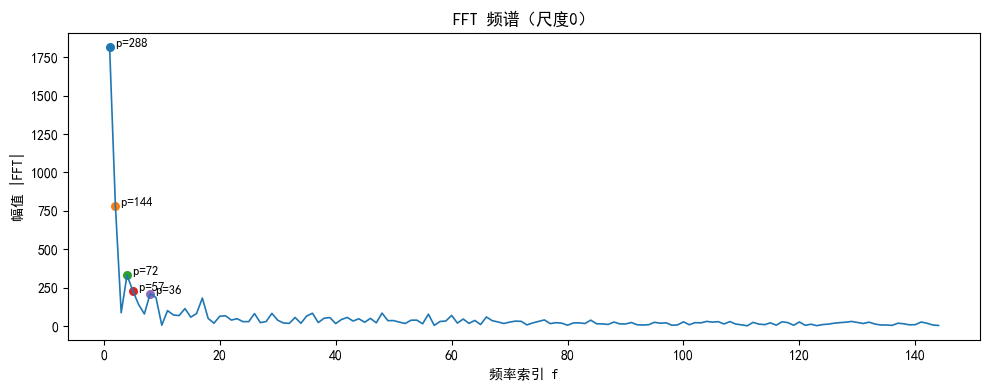

top periods: [288, 144, 72, 57, 36]


In [14]:
def compute_fft_mag_from_x(x_ct: torch.Tensor) -> torch.Tensor:
    if x_ct.dim() != 2:
        raise ValueError('x_ct 必须是 [C, L]')
    _, l = x_ct.shape
    x_ln = F.layer_norm(x_ct, normalized_shape=(l,))
    seq = x_ln.sum(dim=0, keepdim=True)
    fft = torch.fft.rfft(seq, dim=-1)
    mag = torch.abs(fft).squeeze(0)
    if mag.numel() > 0:
        mag[0] = 0.0
    return mag

with torch.no_grad():
    x_ct0 = x0.transpose(1, 2).contiguous()[0]
    info0 = extract_topk_periods(x_ct0.unsqueeze(0), top_k=5)
    mag0 = compute_fft_mag_from_x(x_ct0)

freq = torch.arange(mag0.numel())
plt.figure(figsize=(10, 4))
plt.plot(freq[1:].cpu().numpy(), mag0[1:].cpu().numpy(), linewidth=1.2)
plt.title('FFT 频谱（尺度0）')
plt.xlabel('频率索引 f')
plt.ylabel('幅值 |FFT|')

periods = info0.periods.cpu().numpy().tolist()
L0 = x_ct0.shape[-1]
for p in periods:
    p = int(p)
    f_idx = max(1, L0 // max(1, p))
    if f_idx < mag0.numel():
        plt.scatter([f_idx], [mag0[f_idx].item()], s=30)
        plt.text(f_idx, mag0[f_idx].item(), f' p={p}', fontsize=9)
plt.tight_layout()
plt.show()

print('top periods:', periods)

### 9.2 1D→2D 热力图（单通道 + 通道均值）

我们用 top-1 周期 `p` 把序列重排为 `z2d [C, rows, p]`，并画：
- 单通道：优先选择第一个 target 对应的输入通道（若存在）
- 通道均值：对所有通道求均值后的热力图

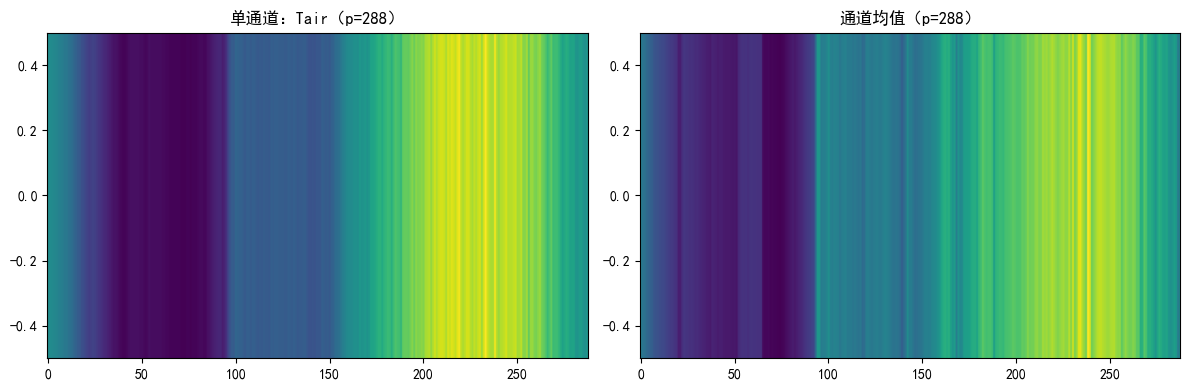

In [15]:
with torch.no_grad():
    x_ct0 = x0.transpose(1, 2).contiguous()[0]
    info0 = extract_topk_periods(x_ct0.unsqueeze(0), top_k=3)
    p0 = int(info0.periods[0].item())
    z2d, _ = reshape_1d_to_2d(x_ct0.unsqueeze(0), period=p0)
    z2d = z2d[0]

if len(prepared.target_cols) > 0 and prepared.target_cols[0] in prepared.feature_cols:
    ch_name = prepared.target_cols[0]
    ch_idx = prepared.feature_cols.index(ch_name)
else:
    ch_name = prepared.feature_cols[0]
    ch_idx = 0

single = z2d[ch_idx].cpu().numpy()
mean_map = z2d.mean(dim=0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(single, aspect='auto', origin='lower')
axes[0].set_title(f'单通道：{ch_name}（p={p0}）')
axes[1].imshow(mean_map, aspect='auto', origin='lower')
axes[1].set_title(f'通道均值（p={p0}）')
plt.tight_layout()
plt.show()

### 9.3 多尺度输出曲线对比（各尺度 vs 融合 vs 真实）

为了画出“每个尺度的预测输出”，这里复现 `TPLCNet.forward()` 的关键逻辑并返回：
- `y_ms`：每个尺度的输出 `[B, pred_len, target_dim]`
- `y_sum`：融合输出（各尺度相加）

同时我们会对 target 维度做反标准化（用 `prepared.target_scaler`）。

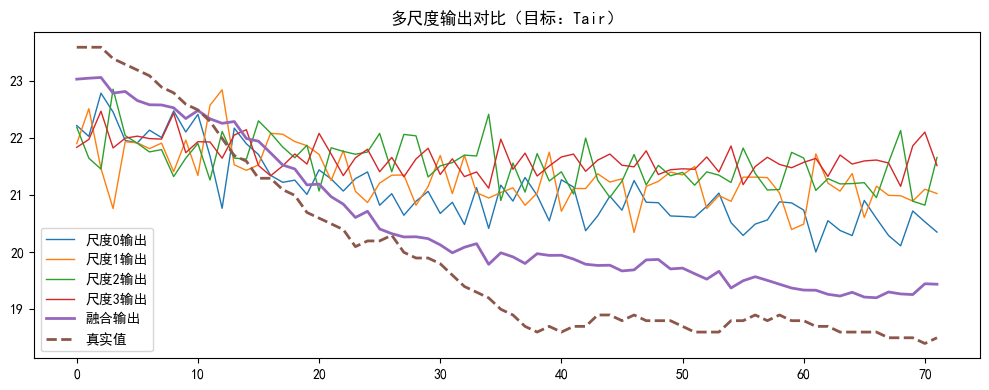

In [16]:
def forward_tplcnet_debug(model: TPLCNet, x: torch.Tensor):
    if x.dim() != 3:
        raise ValueError('x 必须是 [B,T,C]')
    x_ct = x.transpose(1, 2).contiguous()
    scales = model.multi_scale(x_ct)

    y_ms = []
    y_sum = None
    for m, x_m in enumerate(scales):
        info = extract_topk_periods(x_m, top_k=model.top_k_periods)
        weights = torch.softmax(info.amplitudes, dim=0)

        feats = []
        for k in range(model.top_k_periods):
            p = int(info.periods[k].item())
            z2d, orig_len = reshape_1d_to_2d(x_m, period=p)
            y2d = model.conv2d(z2d)
            y1d = reshape_2d_to_1d(y2d, orig_len=orig_len)
            feats.append(y1d)

        fused = 0.0
        for k in range(model.top_k_periods):
            fused = fused + weights[k] * feats[k]

        l_m = fused.shape[-1]
        expected_lm = model.time_projs[m].in_features
        if l_m > expected_lm:
            fused_use = fused[..., -expected_lm:]
        elif l_m < expected_lm:
            fused_use = F.pad(fused, (expected_lm - l_m, 0), value=0.0)
        else:
            fused_use = fused

        pred_hidden = model.time_projs[m](fused_use)
        pred_hidden = pred_hidden.transpose(1, 2).contiguous()
        y_m = model.channel_proj(pred_hidden)

        y_ms.append(y_m)
        y_sum = y_m if y_sum is None else (y_sum + y_m)
    return y_ms, y_sum

with torch.no_grad():
    y_ms, y_sum = forward_tplcnet_debug(model_vis, x0)
    y_true_np = prepared.target_scaler.inverse_transform(y0[0].cpu().numpy())
    y_sum_np = prepared.target_scaler.inverse_transform(y_sum[0].cpu().numpy())
    y_ms_np = [prepared.target_scaler.inverse_transform(y_m[0].cpu().numpy()) for y_m in y_ms]

target_name = prepared.target_cols[0] if len(prepared.target_cols) > 0 else 'target0'
xs = np.arange(pred_len_real)
plt.figure(figsize=(10, 4))
for m, arr in enumerate(y_ms_np):
    plt.plot(xs, arr[:, 0], linewidth=1.0, label=f'尺度{m}输出')
plt.plot(xs, y_sum_np[:, 0], linewidth=2.0, label='融合输出')
plt.plot(xs, y_true_np[:, 0], linewidth=2.0, linestyle='--', label='真实值')
plt.title(f'多尺度输出对比（目标：{target_name}）')
plt.legend()
plt.tight_layout()
plt.show()

## 10. 小结（读完应掌握）

- 你能从 `TPLCNet.forward()` 读出每一步张量形状的变化（`[B,T,C]` ↔ `[B,C,T]` ↔ 多尺度 `[B,C,L_m]` ↔ 2D `[B,C,rows,p]`）。
- 你能解释：为什么要 FFT 找周期、为什么要 1D→2D、为什么用深度可分离卷积。
- 你能在真实温室数据上复现实验可视化：频谱 + 周期标注、单通道/通道均值热力图、多尺度输出曲线。

如果你希望我再补一节“把训练后的 best checkpoint 加载进来再画预测曲线”（而不是用未训练模型），告诉我你想用的结果目录/权重文件名即可。